In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from shapely.geometry import Point, Polygon
from collections import Counter
import geopandas
from geopy.geocoders import Nominatim
import warnings
import json
import requests
import time
import warnings
warnings.filterwarnings('ignore')

/home/frabatx/.local/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
df = pd.read_csv('data/complete.csv')
# Controllo come vengono indicizzate le variabili
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28681 entries, 0 to 28680
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      28681 non-null  object 
 1   day            28681 non-null  int64  
 2   month          28681 non-null  int64  
 3   year           28681 non-null  int64  
 4   list_keywords  28681 non-null  object 
 5   keywords       28681 non-null  object 
 6   title          28665 non-null  object 
 7   subtitle       27094 non-null  object 
 8   text           28681 non-null  object 
 9   address        22536 non-null  object 
 10  location       21186 non-null  object 
 11  geometry       28681 non-null  object 
 12  latitude       28468 non-null  float64
 13  longitude      28468 non-null  float64
 14  cod_quart      11326 non-null  float64
 15  nome_quart     11326 non-null  object 
 16  pro_com        19216 non-null  float64
 17  comune         19216 non-null  object 
dtypes: flo

# Analisi argomentativa
Quali sono le keywords piú frequenti?
1) Keywords totali piú frequenti

2) Frequenza annuale di quelle frequenti

3) Prendere in esempio le keywords di riferimento sulla mappa dei fatti di trento, guardare se hanno pattern

In [3]:
dictionary={
    "Argomenti:" : "",
    "furto" : "furti",
    "orso" : "orsi",
}

for key in dictionary.keys():
    df["keywords"] = df["keywords"].str.replace(key, dictionary[key])
df["keywords"] = df["keywords"].apply(lambda x: re.findall('\'([^\']*)\'', str(x))) # Transform string into list

In [4]:
def uniqueKeyword(listaInDataframe):
    #df_temp = df[df['year']=='2019']
    temp_l = list(listaInDataframe)
    temp_l = [j for i in temp_l for j in i]
    cnt = Counter(temp_l)

    key_value_count = cnt.most_common()
    key_value_count.sort(key= lambda x: x[1], reverse=True)
    total_keywords = [[x,y] for x,y in key_value_count]
    #print(len(total_keywords))
    return total_keywords

totalKey = uniqueKeyword(df["keywords"])



In [5]:
totalKey

[['', 2446],
 ['incidenti', 1339],
 ['strade', 873],
 ['furti', 859],
 ['coronavirus', 817],
 ['morti', 766],
 ['viabilità', 737],
 ['lavoro', 694],
 ['scuola', 676],
 ['carabinieri', 654],
 ['ambiente', 604],
 ['meteo', 572],
 ['droga', 567],
 ['università', 540],
 ['trasporti', 520],
 ['montagna', 517],
 ['notizie curiose', 506],
 ['sanità', 497],
 ['incendi', 486],
 ['animali', 462],
 ['sport', 451],
 ['vigili del fuoco', 441],
 ['traffico', 431],
 ['orsi', 430],
 ['politica', 411],
 ['incidenti montagna', 401],
 ['comune', 400],
 ['turismo', 398],
 ['provincia', 382],
 ['neve', 350],
 ['agricoltura', 343],
 ['basket', 329],
 ['sindacati', 323],
 ['volley', 303],
 ['soccorsi alpino', 300],
 ['salute', 290],
 ['sci', 283],
 ['natura', 278],
 ['calcio', 271],
 ['aquila basket', 266],
 ['a22', 262],
 ['arresti', 260],
 ['maltempo', 260],
 ['Elisoccorsi', 260],
 ['tribunale', 256],
 ['lavori pubblici', 256],
 ['musica', 252],
 ['truffe', 235],
 ['giovani', 233],
 ['eventi', 231],
 ['sci

In [6]:
# Somma totale di tutte le keyword uniche 
len(totalKey)

4850

In [7]:
# Studio la variazione delle keywords per ogni anno. Quali sono i trend topic annuali?
years = df.year.unique()

for year in years:
    df_year = df[df['year']==year]
    print(year)
    print(list(uniqueKeyword(df_year['keywords']))[:21])

2020
[['coronavirus', 817], ['', 209], ['trasporti', 176], ['morti', 134], ['orsi', 120], ['strade', 118], ['viabilità', 97], ['incidenti', 87], ['contagi', 80], ['covid', 70], ['Maurizio Fugatti', 70], ['morti coronavirus', 67], ['scuola', 66], ['animali', 63], ['soccorsi alpino', 63], ['mobilità', 61], ['tamponi', 58], ['elezioni comunali trento 2020', 58], ['trento', 57], ['vigili del fuoco', 53], ['dpcm', 52]]
2019
[['strade', 249], ['', 195], ['incidenti', 164], ['morti', 143], ['viabilità', 139], ['trasporti', 133], ['montagna', 115], ['animali', 102], ['droga', 94], ['meteo', 90], ['notizie curiose', 80], ['neve', 78], ['incendi', 74], ['furti', 70], ['mobilità', 67], ['trasporto', 66], ['orsi', 62], ['vigili del fuoco', 61], ['ambiente', 60], ['traffico', 59], ['soccorsi alpino', 59]]
2018
[['', 240], ['incidenti', 173], ['strade', 162], ['viabilità', 125], ['montagna', 118], ['morti', 116], ['elezioni provinciali 2018', 115], ['meteo', 109], ['droga', 104], ['notizie curiose',

# Analisi Temporale
Frequenza degli articoli annuali, quanti articoli escono all'anno? qual è la crescita? 

* Quali sono i mesi piú caldi dal punto di vista dell'informazione? Anni?

Lo studio ha dimostrato che per quanto riguarda gli anni non c'è una sostanziale crescita o decrescita dal punto di vista della pubblicazione degli articoli. In genere parliamo di una media di 3000 articoli l'anno che possono variare nell'ordine delle centinaia. I dati del 2020 non sono completi poiché si fermano ad inizio Novembre ma vedendo l'andamento degli anni precedenti si puó stimare una pubblicazione di altri ______ articoli.
L'analisi che segue mostra l'andamento delle pubblicazioni in ordine temporale. La prima immagine descrive l'analisi annuale e la seconda l'andamento mensile nel corso di 8 anni di pubblicazioni.
A spiccare sono proprio alcuni mesi che vedono un picco di crescita nell'ordine delle centinaia di articoli. I mesi in questione sono spesso quelli di ritorno dalle vacanze estive come Settembre ed Ottobre. 
Il 2020 é un anno particolare da questo punto di vista, complice la pandemia. Infatti vediamo come nel periodo di Marzo, Aprile le pubblicazioni siano state piú alte della norma, per non parlare di una fortissima diminuzione ad Agosto, riscontrata ogni anno ma accentuata in questo specifico periodo, ed una ripresa impressionante al ritorno delle vacanze che ha portato ad un divario tra agosto e ottobre di circa 150 articoli in piú.

Analizzando quelli che sono gli argomenti principali dei vari mesi ovviamente il coronavirus é il trend topic di questo 2020. 
Ricordarsi che il grafico deve avere per ogni punto anche il topic principale del mese.


In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [9]:
# Documentazione groupby per le frequenze delle date
year_frequency = df.groupby(pd.Grouper(key='timestamp', freq='1Y')).size().reset_index(name='counts')
month_frequency = df.groupby(pd.Grouper(key='timestamp', freq='1M')).size().reset_index(name='counts')

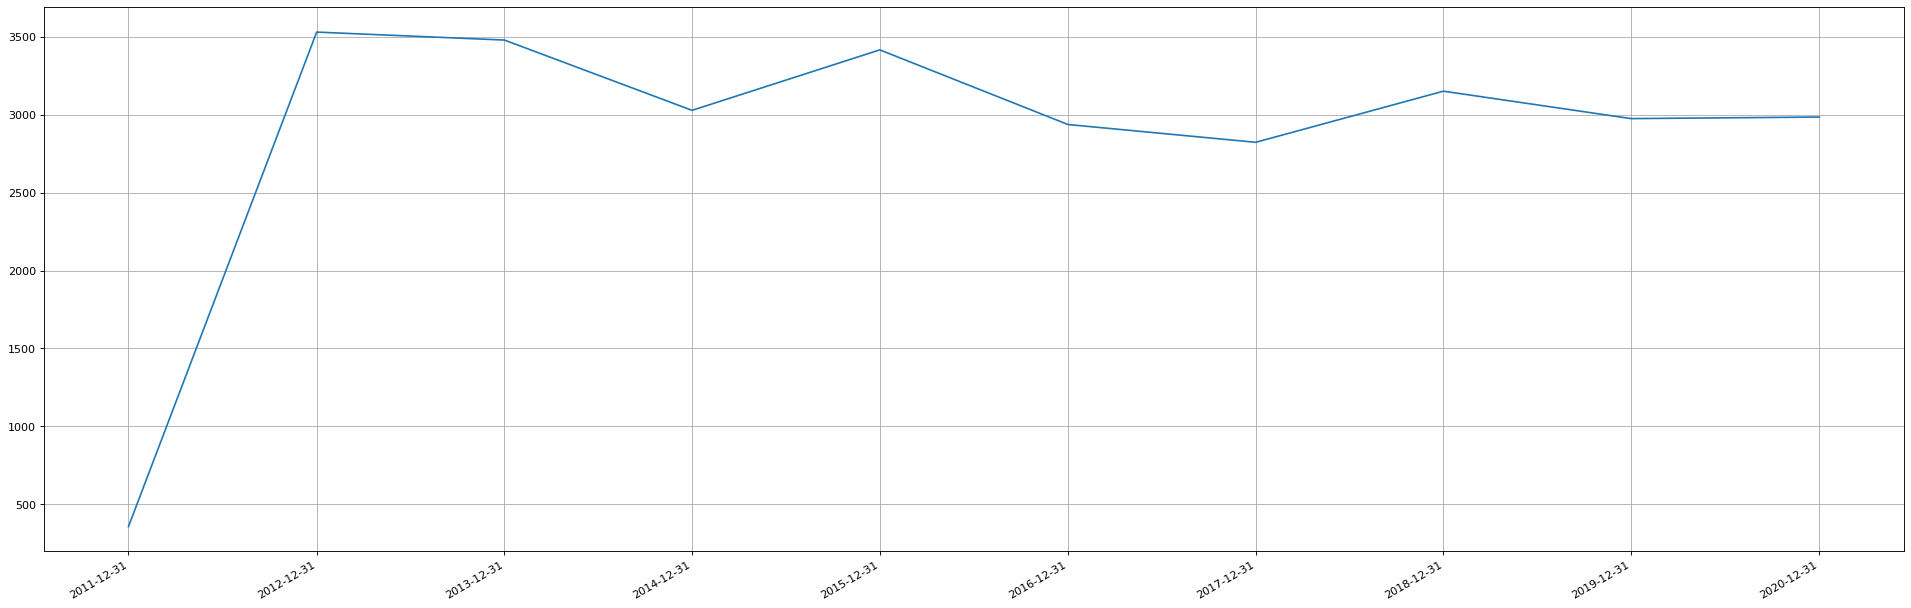

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(30,10), dpi=80, facecolor='w', edgecolor='k')

y = year_frequency['timestamp'].to_list()
c = year_frequency['counts'].to_list()
plt.plot(y,c)
plt.xticks(y)
plt.gcf().autofmt_xdate()
plt.grid(True)

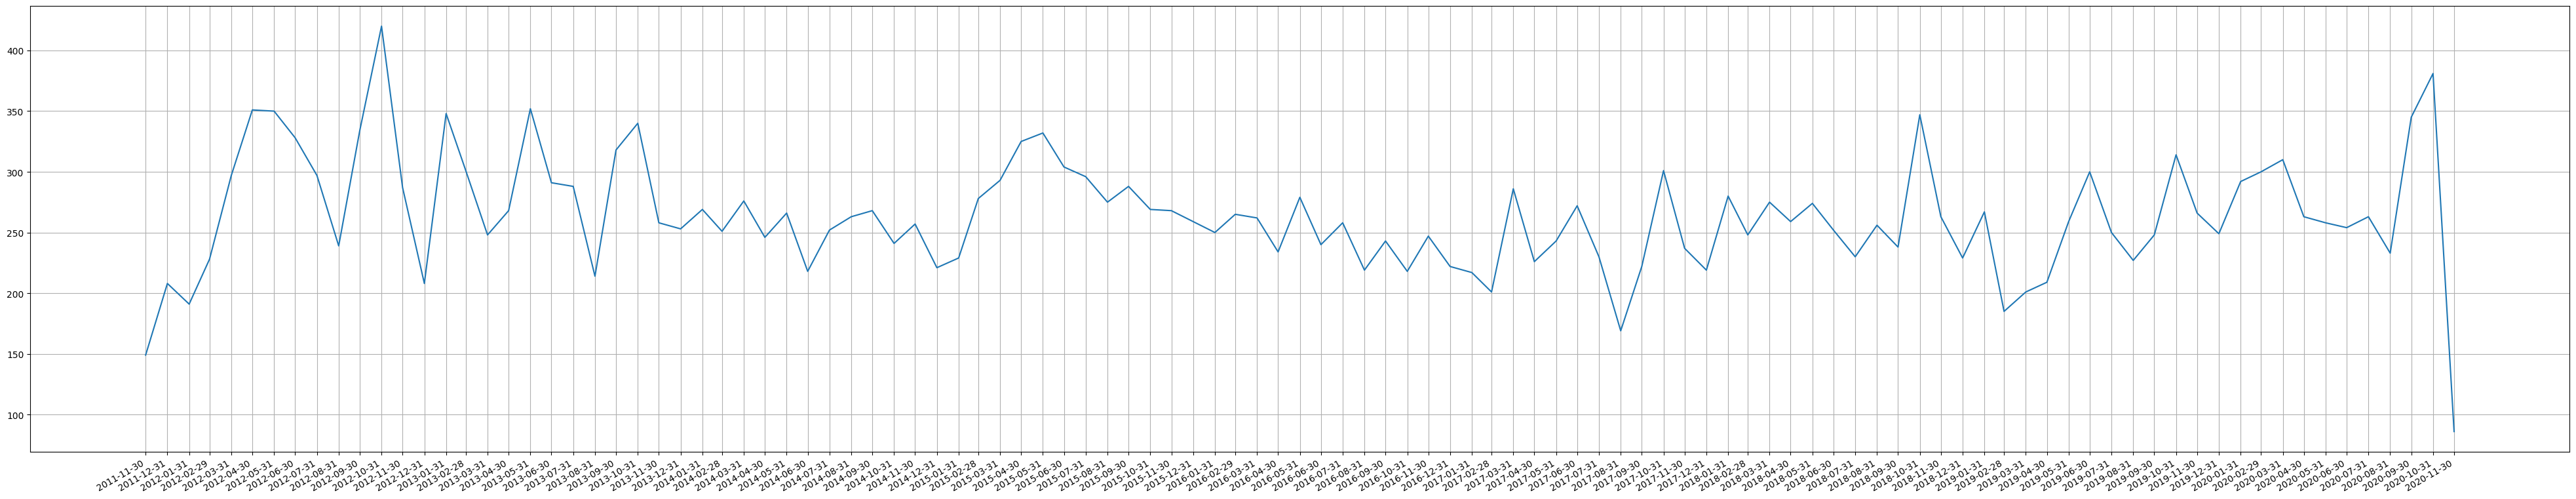

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(50,10), dpi=100, facecolor='w', edgecolor='k')

y = month_frequency['timestamp'].to_list()
c = month_frequency['counts'].to_list()
ax = plt.plot(y,c)
plt.xticks(y)
plt.gcf().autofmt_xdate()
plt.grid(True)

Lo studio porta a pensare che ci sono mesi che hanno dei picchi particolari, come Settembre ed ottobre. Controllo i top 15 mesi per frequenza e trovo 8 su 15 sono settembre ed ottobre rispetto agli altri mesi. Ma cosa pubblicano?

In [12]:
display(month_frequency.sort_values('counts', ascending=True).head(15))

,timestamp,counts
108,2020-11-30,86
0,2011-11-30,149
69,2017-08-31,169
87,2019-02-28,185
2,2012-01-31,191
88,2019-03-31,201
63,2017-02-28,201
1,2011-12-31,208
13,2012-12-31,208
89,2019-04-30,209


In [13]:
ottobre2017 = df.loc[(df['timestamp'].dt.month == 10)&(df['timestamp'].dt.year == 2017)]
listaKeyOttobre2017 = uniqueKeyword(ottobre2017["keywords"])
ottobre2018 = df.loc[(df['timestamp'].dt.month == 10)&(df['timestamp'].dt.year == 2018)]
listaKeyOttobre2018 = uniqueKeyword(ottobre2018["keywords"])
ottobre2019 = df.loc[(df['timestamp'].dt.month == 10)&(df['timestamp'].dt.year == 2019)]
listaKeyOttobre2019 = uniqueKeyword(ottobre2019["keywords"])
ottobre2020 = df.loc[(df['timestamp'].dt.month == 10)&(df['timestamp'].dt.year == 2020)]
listaKeyOttobre2020 = uniqueKeyword(ottobre2020["keywords"])

In [14]:
argomenti10Ultimi4Anni = pd.DataFrame(zip(listaKeyOttobre2017,listaKeyOttobre2018,listaKeyOttobre2019,listaKeyOttobre2020), columns=[2017,2018, 2019,2020])

In [15]:
print(argomenti10Ultimi4Anni.head(10).to_string())

               2017                             2018             2019                2020
0        [casa, 47]  [elezioni provinciali 2018, 62]  [trasporti, 33]  [coronavirus, 101]
1            [, 20]                           [, 40]           [, 23]       [contagi, 36]
2   [incidenti, 17]                       [casa, 32]   [mobilità, 20]          [dpcm, 35]
3      [lavoro, 12]                      [meteo, 27]  [incidenti, 19]     [trasporti, 31]
4   [università, 9]                   [trentino, 26]  [trasporto, 18]              [, 28]
5  [arredamento, 9]                     [strade, 18]      [droga, 14]         [covid, 27]
6    [autonomia, 8]                    [allerta, 15]  [viabilità, 12]        [trento, 27]
7        [furti, 7]                  [incidenti, 12]     [strade, 12]       [tamponi, 24]
8      [incendi, 6]                      [droga, 11]      [morti, 10]          [orsi, 23]
9        [meteo, 6]                      [furti, 10]    [ambiente, 9]   [prevenzione, 22]


# Analisi mensile top Keyword
Abbiamo visto negli ultimi anni Ottobre e le sue argomentazioni, ma quali sono le keywords che hanno caratterizzato ogni mese nel corso degli anni?

Per poterlo realizzare posso utilizzare le funzioni che ho giá creato e ciclarle per creare quello che mi serve

In [16]:
rows = []
for year in range(2012,2021):
    
    # ciclo sui mesi
    for month in range(1,13):
        data = df.loc[(df['timestamp'].dt.month == month)&(df['timestamp'].dt.year == year)]
        lista = uniqueKeyword(data["keywords"])
        #print(year, month, lista[:3])
        rows.append(lista[:20])

In [17]:
arrays = [np.array([2012]*12 +[2013]*12 +[2014]*12 +[2015]*12 +[2016]*12 +[2017]*12 +[2018]*12 +[2019]*12 +[2020]*12), 
          np.array([1,2,3,4,5,6,7,8,9,10,11,12]*9)]

In [18]:
dato = pd.DataFrame(rows, index=arrays, columns=range(1,21))

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(dato)

1   \
2012 1                       [incidenti, 12]   
     2                          [calcio, 15]   
     3                       [incidenti, 21]   
     4                       [incidenti, 19]   
     5                       [incidenti, 30]   
     6                       [incidenti, 19]   
     7                       [incidenti, 19]   
     8                       [incidenti, 29]   
     9                       [incidenti, 27]   
     10                      [incidenti, 23]   
     11                      [incidenti, 14]   
     12                      [incidenti, 11]   
2013 1                       [incidenti, 27]   
     2                       [incidenti, 18]   
     3                           [calcio, 8]   
     4                       [incidenti, 27]   
     5                       [incidenti, 21]   
     6                       [incidenti, 11]   
     7                                [, 15]   
     8                                [, 97]   
     9                               [, 118]   
     10                              [, 137]   
     11                               [, 58]   
     12                               [, 80]   
2014 1                                [, 85]   
     2                                [, 58]   
     3                                [, 75]   
     4                                [, 68]   
     5                                [, 58]   
     6                                [, 63]   
     7                                [, 56]   
     8                                [, 49]   
     9                                [, 46]   
     10                               [, 28]   
     11                               [, 27]   
     12                               [, 16]   
2015 1                             [sci, 15]   
     2                                [, 15]   
     3                                [, 29]   
     4                                [, 50]   
     5   [elezioni comunali 2015 trento, 56]   
     6                                [, 33]   
     7                                [, 27]   
     8                       [viabilità, 20]   
     9                          [scuola, 16]   
     10                               [, 24]   
     11                               [, 25]   
     12                               [, 22]   
2016 1                       [incidenti, 15]   
     2                           [furti, 16]   
     3                          [strade, 20]   
     4                                [, 17]   
     5                          [comuni, 19]   
     6                           [furti, 12]   
     7                                [, 20]   
     8                                [, 19]   
     9                                [, 27]   
     10                          [morti, 15]   
     11                               [, 19]   
     12                        [incendi, 11]   
2017 1                                [, 20]   
     2                       [incidenti, 14]   
     3                       [incidenti, 27]   
     4                        [montagna, 15]   
     5                                [, 17]   
     6                                [, 18]   
     7                                [, 16]   
     8                          [scuola, 32]   
     9                                [, 21]   
     10                           [casa, 47]   
     11                      [incidenti, 16]   
     12                               [, 15]   
2018 1                                [, 20]   
     2                       [incidenti, 21]   
     3                                [, 17]   
     4                       [incidenti, 17]   
     5                  [adunata alpini, 38]   
     6                       [incidenti, 23]   
     7                       [incidenti, 21]   
     8                          [scuola, 21]   
     9       [elezioni provinciali 2018, 18]   
     10      [elezioni provinciali 2018, 62]   
     11                       [maltempo, 48]   
     12   

# Analisi Geografica
L'analisi geografica qui rappresentata prende come riferimento il dataset geolocalizzato e lo studia per quelle che possno essere le componenti geografiche e le componenti argomentative.

Qui rispondiamo a domande come:
* Quali sono i topic piú trattati per le notizie geolocalizzate? In questo modo possiamo vedere che tipo di notizie andiamo a trattare. Mi aspetto che siano notizie prevalentemente di incidenti, strade, notizie di quartiere.
* Tra queste notizie quali sono le piú comuni su trento?
* Quali sono i quartieri di trento con piú notizie?
* C'è una sostanziale differenza tra il centro e la periferia?
* Trento VS Comuni. Quali sono le notizie e che tipo di notizie sono quelle nei comuni?
* Occhio mirato sulla criminalità

In [20]:
import pandas as pd
import numpy as np
import datetime
import re
from shapely.geometry import Point, Polygon
from collections import Counter
import geopandas
from geopy.geocoders import Nominatim
import warnings
import json
import requests
import time
import warnings
warnings.filterwarnings('ignore')

In [21]:
df = pd.read_csv('data/complete.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28681 entries, 0 to 28680
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      28681 non-null  datetime64[ns]
 1   day            28681 non-null  int64         
 2   month          28681 non-null  int64         
 3   year           28681 non-null  int64         
 4   list_keywords  28681 non-null  object        
 5   keywords       28681 non-null  object        
 6   title          28665 non-null  object        
 7   subtitle       27094 non-null  object        
 8   text           28681 non-null  object        
 9   address        22536 non-null  object        
 10  location       21186 non-null  object        
 11  geometry       28681 non-null  object        
 12  latitude       28468 non-null  float64       
 13  longitude      28468 non-null  float64       
 14  cod_quart      11326 non-null  float64       
 15  nome_quart     1132

In [22]:
len(df[(df['comune'].notnull())])

19216

I punti trovati in trentino sono 19.216.

Quali sono i topic piú trattati per le notizie geolocalizzate? In questo modo possiamo vedere che tipo di notizie andiamo a trattare. Mi aspetto che siano notizie prevalentemente di incidenti, strade, notizie di quartiere.

In [23]:
dictionary={
    "Argomenti:" : "",
    "furto" : "furti",
    "orso" : "orsi",
}

for key in dictionary.keys():
    df["keywords"] = df["keywords"].str.replace(key, dictionary[key])
df["keywords"] = df["keywords"].apply(lambda x: re.findall('\'([^\']*)\'', str(x))) # Transform string into list

In [24]:
def uniqueKeyword(listaInDataframe):
    #df_temp = df[df['year']=='2019']
    temp_l = list(listaInDataframe)
    temp_l = [j for i in temp_l for j in i]
    cnt = Counter(temp_l)

    key_value_count = cnt.most_common()
    key_value_count.sort(key= lambda x: x[1], reverse=True)
    total_keywords = [[x,y] for x,y in key_value_count]
    #print(len(total_keywords))
    return total_keywords

trento = df[df['comune'] == 'Trento' ]
trentino = df[(df['comune'].notnull())]
nonTrento = df[(df['comune'].notnull())&(df['comune']!="Trento")]
totalKey = uniqueKeyword(df["keywords"])
nonTrentoKey = uniqueKeyword(nonTrento["keywords"])
trentoKey = uniqueKeyword(trento["keywords"])


In [25]:
print("Numero di punti in trentino: ",len(trentino))
print("Numero di punti nei comuni: ",len(nonTrento))
print("Keywors più utilizzate nei comuni: \n", nonTrentoKey[:50])

Numero di punti in trentino:  19216
Numero di punti nei comuni:  7873
Keywors più utilizzate nei comuni: 
 [['incidenti', 763], ['furti', 427], ['', 422], ['carabinieri', 376], ['morti', 366], ['strade', 335], ['incendi', 308], ['viabilità', 250], ['ambiente', 248], ['vigili del fuoco', 232], ['droga', 214], ['incidenti montagna', 212], ['notizie curiose', 210], ['montagna', 201], ['animali', 196], ['soccorsi alpino', 152], ['Elisoccorsi', 152], ['trasporti', 141], ['orsi', 137], ['sci', 134], ['lavoro', 134], ['rovereto', 126], ['natura', 117], ['turismo', 114], ['truffe', 110], ['traffico', 108], ['agricoltura', 103], ['incidenti stradali', 99], ['arresti', 96], ['incidenti motociclistici', 93], ['patente', 86], ['lago di garda', 83], ['sanità', 83], ['sport', 81], ['mobilità', 77], ['scuola', 76], ['comuni', 75], ['incidenti sul lavoro', 75], ['calcio', 73], ['incidente', 72], ['coronavirus', 69], ['indagini', 69], ['minori', 69], ['neve', 68], ['musica', 67], ['investimenti', 66], 

In [26]:
print("Numero di punti a Trento: ",len(trento))
print("Keywors più utilizzate a Trento: \n",trentoKey[:50])

Numero di punti a Trento:  11343
Keywors più utilizzate a Trento: 
 [['', 1209], ['coronavirus', 448], ['università', 365], ['scuola', 329], ['lavoro', 328], ['meteo', 318], ['strade', 311], ['viabilità', 302], ['incidenti', 286], ['furti', 263], ['sport', 259], ['comune', 252], ['basket', 239], ['sanità', 234], ['politica', 231], ['droga', 217], ['traffico', 213], ['notizie curiose', 204], ['morti', 202], ['aquila basket', 201], ['trasporti', 198], ['volley', 181], ['orsi', 180], ['montagna', 176], ['neve', 176], ['sindacati', 170], ['ambiente', 169], ['weekend', 160], ['agricoltura', 159], ['salute', 157], ['animali', 156], ['a22', 156], ['turismo', 151], ['provincia', 150], ['studenti', 150], ['carabinieri', 143], ['lavori pubblici', 142], ['tribunale', 130], ['giovani', 129], ['dati', 126], ['immigrazione', 125], ['eventi', 124], ['autostrada del brennero', 122], ['feste', 122], ['maltempo', 119], ['storia', 118], ['musica', 117], ['economia', 116], ['vigili del fuoco', 116], ['sci

In [27]:
print("Percentuale di notizie su trento")
print((11343/19216)*100)

Percentuale di notizie su trento
59.028934221482096


Questo ci fa capire che le notizie sul coronavirus sono date prevalentemente su Trento, considerando che piú della metá sono geolocalizzate in cittá e solo 69 sono rivolte ai comuni.

Come era prevedibile le notizie principali per i comuni sono gli incidenti, quello che stupisce é che le notizie sui furti siano maggiori nei comuni che in cittá. In realtá non so bene come descrivere quello che ho trovato in questo contesto. Magari é utile contestualizzare il tutto con una mappa che definisce i comuni piú pericolosi magari. Faccio il dataset e vedo.

In [28]:
countArticleComune = nonTrento.groupby(['comune']).size().reset_index(name='counts').sort_values('counts', ascending=False)

Controllo se i comuni che hanno piú articoli sono i piú grandi del Trentino. La risposta é no. Le cittá con piú articoli sono quelle con popolazione maggiore in ordine di densitá di popolazione!!
https://www.tuttitalia.it/trentino-alto-adige/provincia-autonoma-di-trento/88-comuni/popolazione/

In [29]:
import fiona
import geopandas as gpd
fiona.listlayers('data/istat_administrative_units_2020.gpkg')
municipalities = gpd.read_file("data/istat_administrative_units_2020.gpkg",layer="municipalities")
# filter the province
municipalities_province_trento = municipalities[municipalities.COD_PROV==22]
municipalities_province_trento.to_crs("epsg:32633", inplace=True)

In [30]:
municipalities_province_trento['areas'] = municipalities_province_trento['geometry'].area/10**6

In [31]:
municipalities_province_trento = municipalities_province_trento[['COMUNE', 'areas']].sort_values('areas', ascending=False)
municipalities_province_trento = municipalities_province_trento.rename(columns={'COMUNE': 'comune'})

In [32]:
print(pd.merge(countArticleComune, municipalities_province_trento, how='outer', on=['comune']).to_string())

                                comune  counts       areas
0                             Rovereto  1048.0   52.064029
1                       Riva del Garda   463.0   40.991489
2                    Pergine Valsugana   331.0   54.068175
3                                 Arco   290.0   63.525855
4                      Borgo Valsugana   248.0   52.963834
5                             Predazzo   241.0  110.060705
6                              Pinzolo   221.0   68.906353
7    Primiero San Martino di Castrozza   217.0  199.686506
8                                 Cles   207.0   39.340227
9                         Levico Terme   154.0   62.886160
10                                Mori   146.0   33.153300
11                            Cavalese   146.0   45.115251
12                             Canazei   143.0   66.797093
13               San Michele all'Adige   134.0   16.080210
14                               Lavis   126.0   12.527237
15                                 Dro   111.0   28.1894

Controllo quali sono i comuni che hanno piú criminalitá in base alle key che ho trovato:
* Furti
* Incidenti

In [33]:
parolaChiave = nonTrento[nonTrento['keywords'].apply(lambda x: 'incidenti' in x)]

In [34]:
print(parolaChiave.groupby(['year', 'comune']).size().to_string())

year  comune                           
2011  Arco                                  1
      Borgo d'Anaunia                       1
      Campitello di Fassa                   1
      Comano Terme                          1
      Mezzolombardo                         1
      Rovereto                              1
      Terragnolo                            1
2012  Albiano                               4
      Altavalle                             1
      Andalo                                1
      Arco                                  1
      Avio                                  1
      Baselga di Pinè                       2
      Bedollo                               1
      Besenello                             1
      Bleggio Superiore                     2
      Bocenago                              1
      Bondone                               2
      Borgo Valsugana                       2
      Borgo d'Anaunia                       1
      Brentonico                        

L'analisi dei furti nei comuni,divisi per anni fanno capire che sono notizie sparse, non di particolare rilevanza, certo il numero dei comuni li fa spiccare rispetto a Trento, in realtá dipende dal numero.
Rovereto é quella che tra tutti è la piú rilevante, nulla di particolarmente rilevante rispetto a trento, un massimo di 10 notizie annuali.
Queste analisi stanno portando alla conclusione che la principale fonte di notizie sia Trento e non il Trentino.

# Analisi Trento

* Qual è il quartiere con piú notizie? Che tipo di notizie ci sono?

Un problema che ho notato é che il dataset Trento pinga le notizie in centro storico anche quando é solo "Trento" come geolocalizzazione. 
Vedo di togliere quelle che hanno address solo Trento. Facendolo perdo 1000 punti ma quello che ne ricavo é la geolocalizzazione di solo punti che hanno address centro storico.
Ora posso fare l'analisi.

In [35]:
trento

,timestamp,day,month,year,list_keywords,keywords,title,subtitle,text,address,location,geometry,latitude,longitude,cod_quart,nome_quart,pro_com,comune
0,2020-11-08,8,11,2020,"['Strade', 'Trasporti', 'Viabilità']","[strade, trasporti, viabilità]",Arrivano gli alberi di Natale: chiusa la strad...,La strada sarà chiusa durante le operazioni di...,strada chiusa trasporto alberi natale comune ...,"Trento,Piazza del Duomo","""Piazza del Duomo, Centro storico Trento, Tren...",POINT (11.1210924 46.0676474),46.067647,11.121092,1.0,CENTRO STORICO,22205.0,Trento
1,2020-11-08,8,11,2020,"['Alpini', 'Esercito', 'Tamponi']","[alpini, esercito, tamponi]",Tamponi: anche a Trento arriva l'esercito,Operazione del Ministero della Difesa in suppo...,arriva trento punto tamponi gestito dall eser...,"Trento,Via Fersina","""Via Fersina, Man Malpensada, Clarina, Trento,...",POINT (11.13275943562951 46.05779705000001),46.057797,11.132759,26.0,BOLGHERA,22205.0,Trento
2,2020-11-07,7,11,2020,"['Bollettino', 'Contagi', 'Coronavirus']","[bollettino, contagi, coronavirus]",Bollettino coronavirus: 251 nuovi casi in Tren...,Non accenna a diminuire il contagio: ecco i da...,accenna appiattirsi linea contagi trentino 25...,"Trento,Largo Medaglie d'oro","""Largo Medaglie d'Oro, Man Malpensada, Bolgher...",POINT (11.13275943562951 46.05779705000001),46.057797,11.132759,26.0,BOLGHERA,22205.0,Trento
5,2020-11-07,7,11,2020,"['Coronavirus', 'Negozi', 'Chiusi', 'Supermerc...","[coronavirus, negozi chiusi, supermercati aperti]","Supermercati di nuovo aperti nel weekend, chiu...","L'ordinanza di Fugatti si adegua al Dpcm, sul ...",negozi supermercati aperti sabato domenica no...,"Trento,Via Giannantonio Manci","""Via Giannantonio Manci, Centro storico Trento...",POINT (11.1244551 46.07008370000001),46.070084,11.124455,1.0,CENTRO STORICO,22205.0,Trento
6,2020-11-06,6,11,2020,['Ordine'],"[ordine"", , , , , , , , , ]","Trento, chiusa via Verdi: si sospetta una mani...","La zona è presidiata da polizia, carabinieri, ...",sospetta protesta autorizzata portato chiusur...,"Trento,Via Giuseppe Verdi","""Via Giuseppe Verdi, Laboratorio Sociale Offic...",POINT (11.1145588 46.0662443),46.066244,11.114559,20.0,SAN GIUSEPPE,22205.0,Trento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28613,2011-11-18,18,11,2011,['Manifestazioni'],[manifestazioni],"Partono i Mercatini di Natale, inaugurazione t...",I commercianti del centro città sono indiavola...,linaugurazione casette trento stagione mercat...,Trento,"Trento, Territorio Val d'Adige, Provincia di T...",POINT (11.1257601 46.0664228),46.066423,11.125760,1.0,CENTRO STORICO,22205.0,Trento
28614,2011-11-18,18,11,2011,['Infrastrutture'],[infrastrutture],"Piazza Fiera, pronta la corsia unica per gli a...",Il nuovo percorso non invade la carreggiata e ...,conclusi lavori riorganizzazione viabilistica...,Trento,"Trento, Territorio Val d'Adige, Provincia di T...",POINT (11.1257601 46.0664228),46.066423,11.125760,1.0,CENTRO STORICO,22205.0,Trento
28617,2011-11-17,17,11,2011,['Manifestazioni'],[manifestazioni],Trento città del Natale: tutte le iniziative f...,Musica e giochi per bambini in piazza Duomo. A...,quest’anno trento trasforma città natale,Trento,"Trento, Territorio Val d'Adige, Provincia di T...",POINT (11.1257601 46.0664228),46.066423,11.125760,1.0,CENTRO STORICO,22205.0,Trento
28624,2011-11-16,16,11,2011,['Società'],[società],Nasce anche a Trento un gruppo di scout musulmani,Si tratta della quarta esperienza dell'Aism in...,"zouhaier, tunisino origine, italia 1989, fond...",Gardolo,"Gardolo, Trento, Territorio Val d'Adige, Provi...",POINT (11.1100404 46.1074737),46.107474,11.110040,9.0,GARDOLO,22205.0,Trento


In [36]:
# Tolgo gli address che contengono solo Trento perché vengono pingati in =centro storico
trento = trento[trento['address']!="Trento"]
trentoKey

[['', 1209],
 ['coronavirus', 448],
 ['università', 365],
 ['scuola', 329],
 ['lavoro', 328],
 ['meteo', 318],
 ['strade', 311],
 ['viabilità', 302],
 ['incidenti', 286],
 ['furti', 263],
 ['sport', 259],
 ['comune', 252],
 ['basket', 239],
 ['sanità', 234],
 ['politica', 231],
 ['droga', 217],
 ['traffico', 213],
 ['notizie curiose', 204],
 ['morti', 202],
 ['aquila basket', 201],
 ['trasporti', 198],
 ['volley', 181],
 ['orsi', 180],
 ['montagna', 176],
 ['neve', 176],
 ['sindacati', 170],
 ['ambiente', 169],
 ['weekend', 160],
 ['agricoltura', 159],
 ['salute', 157],
 ['animali', 156],
 ['a22', 156],
 ['turismo', 151],
 ['provincia', 150],
 ['studenti', 150],
 ['carabinieri', 143],
 ['lavori pubblici', 142],
 ['tribunale', 130],
 ['giovani', 129],
 ['dati', 126],
 ['immigrazione', 125],
 ['eventi', 124],
 ['autostrada del brennero', 122],
 ['feste', 122],
 ['maltempo', 119],
 ['storia', 118],
 ['musica', 117],
 ['economia', 116],
 ['vigili del fuoco', 116],
 ['scioperi', 115],
 ['Ma

In [37]:
# Dove sono collocate le notizie di furti e droga?
trento[trento['keywords'].apply(lambda x: 'droga' in x)].groupby(['nome_quart']).size().reset_index(name='counts').sort_values('counts', ascending=False)

,nome_quart,counts
5,CENTRO STORICO,83
20,SOLTERI-CENTOCHIAVI,19
15,SAN BERNARDINO,18
0,BOLGHERA,13
16,SAN GIUSEPPE,10
8,GARDOLO,9
17,SAN MARTINO,8
11,MATTARELLO,6
12,PIEDICASTELLO,5
6,CLARINA,5


In [38]:
# Il centro storico é quello piú rappresentativo della cittá 
centro = trento[trento['nome_quart']== "Centro Storico".upper()]

In [39]:
print(centro[centro['keywords'].apply(lambda x: 'droga' in x)].groupby(pd.Grouper(key='timestamp', freq = '1Y')).size().reset_index(name='counts').to_string())

   timestamp  counts
0 2012-12-31       6
1 2013-12-31       7
2 2014-12-31       1
3 2015-12-31       8
4 2016-12-31       6
5 2017-12-31       8
6 2018-12-31      15
7 2019-12-31      25
8 2020-12-31       7


In [40]:
print(centro[(centro['keywords'].apply(lambda x: 'droga' in x))&(centro['year'] == 2016)]['title'].to_list())

['Spacciatore arrestato: accusato della morte di un ragazzo per overdose', 'Droga, sgominata una banda a Trento: 16 arresti', 'Sei rapine in 24 ore appena uscito dal carcere, minaccia le vittime con una siringa', 'Piazza Dante: arrestato uno spacciatore con un etto di hashish e mille euro', 'Andreatta: "Bene gli arresti, a beneficio dei rifugiati onesti"', "Fermati in Lung'Adige con mezzo chilo di marijuana in auto"]


In [41]:
trento[trento['keywords'].apply(lambda x: 'furti' in x)].groupby(['nome_quart']).size().reset_index(name='counts').sort_values('counts', ascending=False)

,nome_quart,counts
4,CENTRO STORICO,47
1,BOLGHERA,31
24,SOLTERI-CENTOCHIAVI,26
19,SAN BERNARDINO,25
20,SAN GIUSEPPE,19
8,GARDOLO,12
5,CLARINA,11
7,CRISTO RE,10
14,PIEDICASTELLO,9
21,SAN MARTINO,8


In [42]:
print(trento[trento['keywords'].apply(lambda x: 'furti' in x)].groupby(['year','nome_quart']).size().to_string())#.sort_values('counts', ascending=False)

year  nome_quart             
2011  CLARINA                     1
      CRISTO RE                   1
      SAN MARTINO                 1
2012  BELVEDERE-SAN FRANCESCO     1
      BOLGHERA                    2
      CENTRO STORICO              4
      CLARINA                     1
      COGNOLA                     1
      CRISTO RE                   1
      GARDOLO                     4
      POVO                        1
      RONCAFORT                   1
      SAN GIUSEPPE                1
      SAN MARTINO                 2
      SANTISSIMO                  1
      SOLTERI-CENTOCHIAVI         1
      SPINI-GHIAIE                1
      VALSORDA                    1
      VILLAZZANO                  3
2013  BELVEDERE-SAN FRANCESCO     1
      BOLGHERA                    3
      CENTRO STORICO              3
      CLARINA                     1
      CRISTO RE                   2
      GARDOLO                     1
      MADONNA BIANCA              1
      MATTARELLO                  

In [43]:
print(centro[centro['keywords'].apply(lambda x: 'furti' in x)].groupby(pd.Grouper(key='timestamp', freq = '1Y')).size().reset_index(name='counts').to_string())

   timestamp  counts
0 2012-12-31       4
1 2013-12-31       3
2 2014-12-31       4
3 2015-12-31      14
4 2016-12-31      10
5 2017-12-31       0
6 2018-12-31       4
7 2019-12-31       4
8 2020-12-31       4


In [44]:
print(centro[(centro['keywords'].apply(lambda x: 'furti' in x))&(centro['year'] == 2016)]['title'].to_list())

['Infrange la vetrina di un negozio con un tombino e ruba vestiti per 8000 euro', 'Tre furti e una rapina in due giorni: finisce in carcere', 'Amatrice: i soccorritori trentini sventano un episodio di sciacallaggio', 'L\'antifurto si può detrarre dalle tasse. CNA: "Attenzione ai kit fai-da-te"', "Legittima difesa: 1100 firme in una settimana a Trento per il Ddl dell'italia dei Valori", 'Rubò 100 euro da un distributore di sigarette: arrestato sei mesi dopo', "Furto al supermercato di via Roma: il ladro rimane bloccato all'interno", 'La banda dello "Spritz" investiva il bottino dei furti alle slot machine', 'Sicurezza: telecamere in rete, anche quelle private', "Furti, oggi il comitato per l'ordine pubblico"]


# Analisi Argomentativa
In questa analisi studio le co-occorrenze tra le keywords per capire se in qualche modo alcuni argomenti possano essere collegati e trovare qualche relazione in particolare. 

In [45]:
import pandas as pd
import numpy as np
import datetime
import re
from shapely.geometry import Point, Polygon
from collections import Counter
import geopandas
from geopy.geocoders import Nominatim
import warnings
import json
import requests
import time
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [46]:
df = pd.read_csv('data/complete.csv')
# Controllo come vengono indicizzate le variabili
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28681 entries, 0 to 28680
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      28681 non-null  object 
 1   day            28681 non-null  int64  
 2   month          28681 non-null  int64  
 3   year           28681 non-null  int64  
 4   list_keywords  28681 non-null  object 
 5   keywords       28681 non-null  object 
 6   title          28665 non-null  object 
 7   subtitle       27094 non-null  object 
 8   text           28681 non-null  object 
 9   address        22536 non-null  object 
 10  location       21186 non-null  object 
 11  geometry       28681 non-null  object 
 12  latitude       28468 non-null  float64
 13  longitude      28468 non-null  float64
 14  cod_quart      11326 non-null  float64
 15  nome_quart     11326 non-null  object 
 16  pro_com        19216 non-null  float64
 17  comune         19216 non-null  object 
dtypes: flo

In [47]:
dictionary={
    "Argomenti:" : "",
    "furto" : "furti",
    "orso" : "orsi",
}

for key in dictionary.keys():
    df["keywords"] = df["keywords"].str.replace(key, dictionary[key])
df["keywords"] = df["keywords"].apply(lambda x: re.findall('\'([^\']*)\'', str(x))) # Transform string into list

In [48]:
#Check unique keywords
def uniqueKeyword(listaInDataframe):
    #df_temp = df[df['year']=='2019']
    temp_l = list(listaInDataframe)
    temp_l = [j for i in temp_l for j in i]
    cnt = Counter(temp_l)

    key_value_count = cnt.most_common()
    key_value_count.sort(key= lambda x: x[1], reverse=True)
    total_keywords = [[x,y] for x,y in key_value_count]
    #print(len(total_keywords))
    return total_keywords

total_keywords = uniqueKeyword(df["keywords"])
list(total_keywords[:200])

[['', 2446],
 ['incidenti', 1339],
 ['strade', 873],
 ['furti', 859],
 ['coronavirus', 817],
 ['morti', 766],
 ['viabilità', 737],
 ['lavoro', 694],
 ['scuola', 676],
 ['carabinieri', 654],
 ['ambiente', 604],
 ['meteo', 572],
 ['droga', 567],
 ['università', 540],
 ['trasporti', 520],
 ['montagna', 517],
 ['notizie curiose', 506],
 ['sanità', 497],
 ['incendi', 486],
 ['animali', 462],
 ['sport', 451],
 ['vigili del fuoco', 441],
 ['traffico', 431],
 ['orsi', 430],
 ['politica', 411],
 ['incidenti montagna', 401],
 ['comune', 400],
 ['turismo', 398],
 ['provincia', 382],
 ['neve', 350],
 ['agricoltura', 343],
 ['basket', 329],
 ['sindacati', 323],
 ['volley', 303],
 ['soccorsi alpino', 300],
 ['salute', 290],
 ['sci', 283],
 ['natura', 278],
 ['calcio', 271],
 ['aquila basket', 266],
 ['a22', 262],
 ['arresti', 260],
 ['maltempo', 260],
 ['Elisoccorsi', 260],
 ['tribunale', 256],
 ['lavori pubblici', 256],
 ['musica', 252],
 ['truffe', 235],
 ['giovani', 233],
 ['eventi', 231],
 ['sci

In [54]:
common200 = total_keywords
mostCommonKey = [row[0] for row in common200[1:]] # seleziono le prime

In [56]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(50,30), dpi=80, facecolor='w', edgecolor='k')

# Creo una lista boleana 
def filter_df(initial_column, key):
    return key in initial_column

def correlationDataFrame(keywords, df, stringKeywordsColumnName):
    matrix = []
    for index, key in enumerate(keywords):
        row = [0] * len(keywords)
        boolean = df[stringKeywordsColumnName].apply(lambda x: filter_df(x, key))
        filtered_df = df[boolean]
        super_lista = []
        for lista in filtered_df[stringKeywordsColumnName]:
            super_lista.extend(lista)
        for indice, chiave in enumerate(keywords):
            #print('index = {}, conto = {}, chiave = {}'.format(indice, super_lista.count(chiave), chiave))
            row[indice] = super_lista.count(chiave)
        #normalizzo la righa, quindi il grafico non potrá essere letto per colonne
        valoremassimo = max(row)
        normalizzata = [x / valoremassimo for x in row]
        matrix.append(normalizzata)
        
    corrdf = pd.DataFrame(np.triu(matrix), columns=keywords, index=keywords)
    
    return  corrdf

corrdf = correlationDataFrame(mostCommonKey, df, 'keywords')
corrdf.to_csv('correlation.csv')


#plt.pcolor(corrdf)
#plt.yticks(np.arange(0.5, len(corrdf.index), 1), corrdf.index)
#plt.xticks(np.arange(0.5, len(corrdf.columns), 1), corrdf.columns)
#plt.gcf().autofmt_xdate()
#plt.show()

<Figure size 4000x2400 with 0 Axes>

In [57]:
corrdf

,incidenti,strade,furti,coronavirus,morti,viabilità,lavoro,scuola,carabinieri,ambiente,...,apnea,Paola Severino,Anna Pilati,Alessio Zanghellini,autoimpiego,Nuova cittadinanza,costume,Dino Piero Giarda,competizioni,Nuova occupazione
incidenti,1.000,0.117,0.000,0.000,0.050,0.074,0.001,0.001,0.004,0.001,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
strade,0.000,1.000,0.001,0.003,0.027,0.446,0.001,0.003,0.007,0.010,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
furti,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.003,0.178,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
coronavirus,0.000,0.000,0.000,1.000,0.034,0.000,0.009,0.039,0.007,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
morti,0.000,0.000,0.000,0.000,1.000,0.007,0.005,0.001,0.010,0.001,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nuova cittadinanza,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
costume,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
Dino Piero Giarda,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
competizioni,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000


In [52]:
lista = []
for index, row in corrdf.iterrows():
    print(row.apply(lambda x: x if x>0.3 else None).to_string())
        

incidenti                       1.000
strade                            nan
furti                             nan
coronavirus                       nan
morti                             nan
viabilità                         nan
lavoro                            nan
scuola                            nan
carabinieri                       nan
ambiente                          nan
meteo                             nan
droga                             nan
università                        nan
trasporti                         nan
montagna                          nan
notizie curiose                   nan
sanità                            nan
incendi                           nan
animali                           nan
sport                             nan
vigili del fuoco                  nan
traffico                          nan
orsi                              nan
politica                          nan
incidenti montagna                nan
comune                            nan
turismo     

In [53]:
print(lista)

[]


l'analisi argomentativa ha portato a capire che nessuna keyword é particolarmente corelata. Pensiamo che sulle prime 200 é stata trovata solo una correlazione che superasse lo 0.4, che comunque é una correlazione debole.